In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import testStreamingSvd
import streamingSvd as algo

In [2]:
# generate scalar AR(p) data
def generateARp(x_init, coeffs, num_steps, noise=0):
    p = x_init.shape[0]
    xs = np.append(x_init, np.zeros((num_steps)))
    for t in range(num_steps):
        eps = np.random.normal(loc=0, scale=noise)
        xs[t+p] = np.dot(coeffs, xs[t:t+p]) + eps
    return xs


# generate vector AR(1) data, init with last column of xs
def generateVAR1(xs, A, num_steps, noise=0):
    n, t = xs.shape
    xs = np.append(xs, np.zeros((n, num_steps)), axis=1)
    for curr_step in range(t, t+num_steps):
        eps = np.random.normal(loc=0, scale=noise, size=n)
        xs[:, curr_step] = np.dot(A, xs[:, curr_step-1]) + eps
    return xs


# get stable (stationary) coeffs for VAR(1) - max eigval < 1
def get_stable_A(n, low=0, upp=2):
    unstable = True
    while unstable:
        A = np.random.uniform(low, upp, size=(n,n))
        evals, _ = np.linalg.eig(A)
        if np.max(np.abs(evals)) < 1:
            unstable = False
    return A


# rotate 3x3 matrix around x axis by angle theta
def rotate_3dx(A, theta):
    rot = np.array([[1, 0, 0], 
                    [0, np.cos(theta), -np.sin(theta)], 
                    [0, np.sin(theta), np.cos(theta)]])
    return np.dot(rot, A)

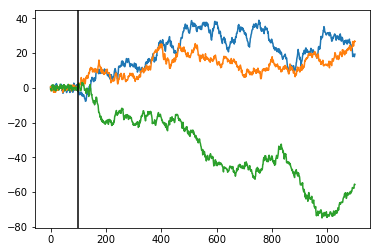

In [40]:
n = 3
numsteps1 = 100
numsteps2 = 1000
sigma = 1

# A1 almost diagonal, 0 out last entry
A1 = np.diag(np.random.uniform(0, 1, size=n))
A1[n-1, n-1] = 0
x_init = np.random.uniform(-1, 1, size=(n, 1))
xs = generateVAR1(x_init, A1, numsteps1, noise=sigma)

# nice oscillations
A2 = np.array([
       [ 0.9767596 , -0.28857368,  0.4491203 ],
       [ 0.97991711,  0.49943434,  0.32865101],
       [ 0.59191832, -0.16951207,  0.57953176]])
# A2 = get_stable_A(n)
xs = generateVAR1(xs, A2, numsteps2, noise=sigma)

plt.plot(xs.T)
plt.axvline(numsteps1, color='k')

In [41]:
# variance
_, S1, _ = np.linalg.svd(xs[:, :100])
_, S2, _ = np.linalg.svd(xs)
print(S1)
print(S2)

[12.2064953  10.23071518  8.60589872]
[1551.19179981  309.88712948  155.97683665]


In [42]:
# streaming svd Qs
# init with l1=3 cols, add l=1 cols at a time for 100 iters
Q1true, Q1 = algo.getSvd(xs, k=n, l1=3, l=1, num_iter=100, decay_alpha=.9)

# add l=1 cols at a time for 1100 iters
Q2true, Q2 = algo.getSvd(xs, k=n, l1=3, l=1, num_iter=1100, decay_alpha=.9)

print('True (rotated) Qs: ')
print(Q1true, '\n--')
print(Q2true, '\n')

print('Tracked Qs:')
print(q1, '\n--')
print(q2)

True (rotated) Qs: 
[[-0.55768543  0.66146062  0.50145469]
 [ 0.00824696 -0.59967887  0.80019825]
 [ 0.83001141  0.45039438  0.32897713]] 
--
[[ 0.29359664  0.37917138 -0.87751358]
 [ 0.41249931 -0.87835705 -0.24152269]
 [-0.86234873 -0.29106349 -0.41429061]] 

Tracked Qs:
[[-0.40509946  0.88081476  0.24507097]
 [-0.77248663 -0.18637238 -0.6070665 ]
 [-0.48903867 -0.43523636  0.75591698]] 
--
[[-0.40509946  0.88081476  0.24507097]
 [-0.77248663 -0.18637238 -0.6070665 ]
 [-0.48903867 -0.43523636  0.75591698]]


In [46]:
U,S,V = np.linalg.svd(xs)
print(U)
print('--------------')
Qtrue, Q = algo.getSvd(xs, xs.shape[0], 5, 5, 250, decay_alpha=.9)
print(Qtrue)

print('\n-------------\n')

Q, Q_est = algo.getSvd(xs, k=3, l1=4, l=1, num_iter=96)
print(Q_est)
print('-------------')
Q, Q_est = algo.getSvd(xs, k=3, l1=10, l=1, num_iter=250)
print(Q_est)

[[-0.47135119 -0.73944964  0.48066857]
 [-0.27166166 -0.39677984 -0.87679285]
 [ 0.83906376 -0.54385658 -0.01385747]]
--------------
[[ 0.30323892 -0.75231572  0.58486512]
 [ 0.88217578  0.45369459  0.12620268]
 [-0.3602944   0.47768428  0.80125256]]

-------------

[[-0.18380585  0.43195097  0.88296872]
 [-0.66562701 -0.7156734   0.21154733]
 [ 0.7232953  -0.54884419  0.41906319]]
-------------
[[-0.18380585  0.43195097  0.88296872]
 [-0.66562701 -0.7156734   0.21154733]
 [ 0.7232953  -0.54884419  0.41906319]]
